Caltech-101 

In [1]:
!pip install gdown

DataLoader

In [2]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

def ensure_rgb(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return image
def load_caltech101(batch_size=32):
    # Define transforms for preprocessing
    transform = transforms.Compose([
        transforms.Lambda(ensure_rgb),
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])

    # Load the entire Caltech101 dataset
    dataset = datasets.Caltech101(root='./data/101_ObjectCategories', download=True, transform=transform)

    # Get labels and indices
    labels = np.array([target for _, target in dataset])
    
    # Create train and test splits
    train_indices, test_indices = train_test_split(
        np.arange(len(dataset)), test_size=0.3, stratify=labels, random_state=42
    )
  
    # Create subsets for training and testing
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Load the datasets
train_loader, test_loader = load_caltech101()

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=7b4ccf8c-6a4c-4e04-9127-409525f3df26
To: c:\Users\Admin\Downloads\Object_classification\object_classification\data\101_ObjectCategories\caltech101\101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [01:55<00:00, 1.14MB/s] 


Extracting ./data/101_ObjectCategories\caltech101\101_ObjectCategories.tar.gz to ./data/101_ObjectCategories\caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=dc686220-c88e-4f06-a41c-a184524bdb98
To: c:\Users\Admin\Downloads\Object_classification\object_classification\data\101_ObjectCategories\caltech101\Annotations.tar
100%|██████████| 14.0M/14.0M [00:13<00:00, 1.07MB/s]


Extracting ./data/101_ObjectCategories\caltech101\Annotations.tar to ./data/101_ObjectCategories\caltech101


In [3]:
!pip install umap-learn

KNN 

In [4]:
import torchvision.models as models
from torchvision import datasets, transforms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
encoder = models.resnet50(pretrained=True)
encoder = torch.nn.Sequential(*list(encoder.children())[:-1]) #removing final fc
# Extract embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def extract_features(loader, model):
    model.to(device)
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_loader, encoder)
test_features, test_labels = extract_features(test_loader, encoder)
#--------------------- Custom distance
#################################################################
def pairwise_squared_euclidean(X, Y):
    # Compute the squared norms of each row in X and Y
    X_norm_squared = np.sum(X**2, axis=1).reshape(-1, 1)  # Shape (m, 1)
    Y_norm_squared = np.sum(Y**2, axis=1).reshape(1, -1)  # Shape (1, n)
    
    # Compute the pairwise squared Euclidean distances
    distances = X_norm_squared + Y_norm_squared - 2 * np.dot(X, Y.T)
    
    return distances
def custom_distance_metric(x, y):
    # `x` and `y` are single samples, so we need to reshape them as 2D arrays
    x = x.reshape(1, -1)
    y = y.reshape(1, -1)
    return pairwise_squared_euclidean(x, y)[0, 0]  # Return the scalar distance
#-----------------------------------------------------------
# k-NN Classification
knn = KNeighborsClassifier(n_neighbors=5, metric=custom_distance_metric)
knn.fit(train_features, train_labels)
test_preds = knn.predict(test_features)
accuracy = accuracy_score(test_labels, test_preds)
print(f'k-NN Test Accuracy: {accuracy * 100:.2f}%')

c:\Users\Admin\anaconda3\envs\scio\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\scio\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


k-NN Test Accuracy: 89.25%


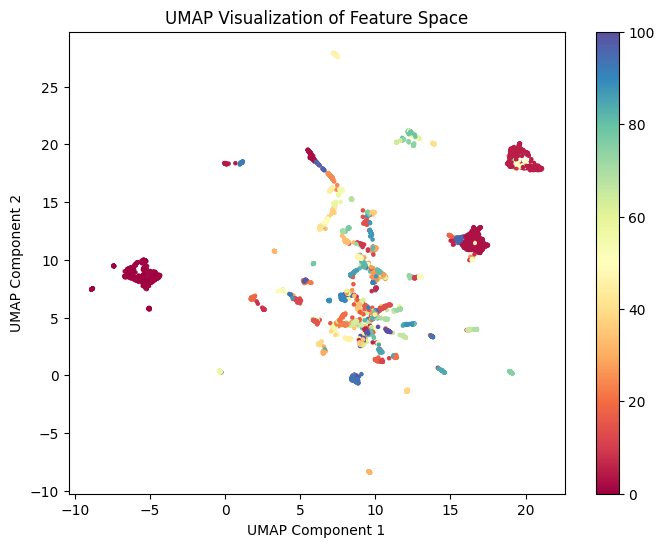

In [5]:
import umap
import matplotlib.pyplot as plt
def visualize_umap(features, labels):
    reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')
    umap_embeddings = reducer.fit_transform(features)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='Spectral', s=5)
    plt.title('UMAP Visualization of Feature Space')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.colorbar()
    plt.show()

# Visualize training features
visualize_umap(train_features, train_labels)

Frozen Resnet Encoder with last FC layer as classifier

c:\Users\Admin\anaconda3\envs\scio\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\scio\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.6154, Train Accuracy: 71.94%
Validation Accuracy: 88.56%
Epoch [2/10], Loss: 0.2125, Train Accuracy: 93.38%
Validation Accuracy: 90.63%
Epoch [3/10], Loss: 0.0612, Train Accuracy: 96.13%
Validation Accuracy: 92.05%
Epoch [4/10], Loss: 0.0923, Train Accuracy: 97.37%
Validation Accuracy: 91.59%
Epoch [5/10], Loss: 0.0675, Train Accuracy: 98.32%
Validation Accuracy: 92.43%
Epoch [6/10], Loss: 0.0861, Train Accuracy: 98.67%
Validation Accuracy: 92.05%
Epoch [7/10], Loss: 0.0156, Train Accuracy: 99.04%
Validation Accuracy: 92.74%
Epoch [8/10], Loss: 0.0565, Train Accuracy: 99.13%
Validation Accuracy: 92.70%
Epoch [9/10], Loss: 0.0534, Train Accuracy: 99.18%
Validation Accuracy: 93.01%
Epoch [10/10], Loss: 0.0136, Train Accuracy: 99.42%
Validation Accuracy: 93.28%


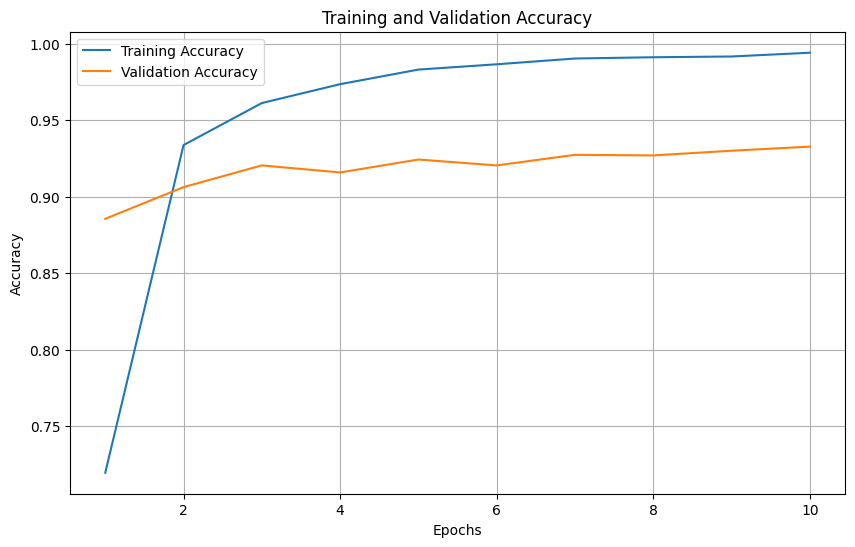

Frozen Encoder - FC linear - Test Accuracy: 93.28%


In [6]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Define the model with a frozen ResNet-50 encoder
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Classifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False  # Freeze the feature extractor
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # New FC layer

    def forward(self, x):
        return self.resnet(x)



# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = ResNet50Classifier(num_classes=101)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.001)

# Lists to store training and validation accuracies
train_accuracies = []
val_accuracies = []

# Train the model
num_epochs = 10  # Adjust as necessary
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy * 100:.2f}%')

    # Evaluate on validation set
    model.eval()
    correct_val = 0
    total_val = 0
    test_features, test_labels = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            test_features.append(outputs.cpu().numpy())
            test_labels.append(targets.cpu().numpy())
    
    test_features = np.concatenate(test_features)
    test_labels = np.concatenate(test_labels)

    # Calculate accuracy
    test_preds = np.argmax(test_features, axis=1)
    test_accuracy = accuracy_score(test_labels, test_preds)
    val_accuracies.append(test_accuracy)
    print(f'Validation Accuracy: {test_accuracy * 100:.2f}%')

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Evaluate the model on test set
model.eval()
test_features, test_labels = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        test_features.append(outputs.cpu().numpy())
        test_labels.append(targets.cpu().numpy())

test_features = np.concatenate(test_features)
test_labels = np.concatenate(test_labels)

# Calculate accuracy
test_preds = np.argmax(test_features, axis=1)
accuracy = accuracy_score(test_labels, test_preds)
print(f'Frozen Encoder - FC linear - Test Accuracy: {accuracy * 100:.2f}%')

**Fine Tuned Model**

Data Augmentations

In [7]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Ensure images are in RGB format
def ensure_rgb(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return image

def load_caltech101(batch_size=32):
    # Define data augmentation for the training set
    train_transform = transforms.Compose([
        transforms.Lambda(ensure_rgb),
        transforms.RandomResizedCrop(224),  # Randomly crop and resize the image
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomRotation(30),  # Randomly rotate the image by 30 degrees
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),  
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ])

    # Define basic transformations for the test set
    test_transform = transforms.Compose([
        transforms.Lambda(ensure_rgb),
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ])

    # Load the entire Caltech101 dataset with test and train transforms
    dataset = datasets.Caltech101(root='./data/101_ObjectCategories', download=True, transform=None)

    # Get labels and indices
    labels = np.array([target for _, target in dataset])

    # Create train and test splits
    train_indices, test_indices = train_test_split(
        np.arange(len(dataset)), test_size=0.3, stratify=labels, random_state=42
    )

    # Create subsets for training and testing
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    # Apply transforms to the subsets
    train_dataset.dataset.transform = train_transform  # Apply the train transform
    test_dataset.dataset.transform = test_transform  # Apply the test transform

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Load the datasets
train_loader, test_loader = load_caltech101()

Files already downloaded and verified


Learning Rate Schedular with Warmup Ramp and then Expotentional Decay

In [8]:
class WarmupExponentialLR:
    def __init__(self, optimizer, warmup_epochs, initial_lr, max_lr, decay_rate, lr_min):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.decay_rate = decay_rate
        self.lr_min = lr_min
        self.current_epoch = 0

    def step(self):
        self.current_epoch += 1

        # Warmup phase
        if self.current_epoch <= self.warmup_epochs:
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * (self.current_epoch / self.warmup_epochs)
        else:
            # Exponential decay phase
            decay_epochs = self.current_epoch - self.warmup_epochs
            decay_epochs_tensor = torch.tensor(decay_epochs, dtype=torch.float)
            lr = self.lr_min + (self.max_lr - self.lr_min) * torch.exp(-self.decay_rate * decay_epochs_tensor)
            #lr = self.lr_min + (self.max_lr - self.lr_min) * torch.exp(-self.decay_rate * decay_epochs)

        # Update the learning rate for each parameter group
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
    def get_lr(self):
        # Return the current learning rate for all parameter groups
        return self.optimizer.param_groups[0]['lr']

Gradual Unfreezing of the Model Layers

In [9]:
def unfreeze_layers(model, blocks_to_unfreeze):

    layers = list(model.resnet.named_children())[:-2]  # Exclude AdaptiveAvgPool and FC layer
    num_blocks = len(layers)  # Number of blocks in ResNet-50

    if blocks_to_unfreeze > 0:
        print(f"\nUnfreezing the last {blocks_to_unfreeze} blocks of ResNet-50:")
        for i, (name, block) in enumerate(layers[-blocks_to_unfreeze:], 1):
            for param in block.parameters():
                param.requires_grad = True
                block_info = str(block)[:100]
            print(f"Unfrozen Block {num_blocks - blocks_to_unfreeze + i} ({name}): {block_info}.....")

Training

In [10]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torchvision.models as models
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ResNet50Classifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.dropout = nn.Dropout2d(dropout_rate)
        for param in self.resnet.parameters():
            param.requires_grad = False  # Freeze the feature extractor
        self.resnet.fc = nn.Sequential(
            #nn.Linear(self.resnet.fc.in_features, 256),  # Add a hidden layer
            #nn.ReLU(),
            nn.Dropout(dropout_rate),  # Add dropout
            nn.Linear(self.resnet.fc.in_features, num_classes)  # New FC layer for output
        )

    def forward(self, x):
        return self.resnet(x)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Classifier(num_classes=101)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.001, weight_decay=1e-4)  

# Initialize the custom learning rate scheduler
warmup_epochs = 10  # Number of warmup epochs
initial_lr = 0.000001  # Starting learning rate for warmup
max_lr = 0.0001  # Maximum learning rate
decay_rate = 0.1  # Rate of exponential decay
lr_min = 0.000001  # Minimum learning rate

scheduler = WarmupExponentialLR(optimizer, warmup_epochs, initial_lr, max_lr, decay_rate, lr_min)

# Lists to store training and validation accuracies
train_accuracies = []
val_accuracies = []
learning_rates = []

num_epochs = 20  # Total number of epochs

num_blocks = 4
unfreeze_range_low=4
unfreeze_range_high=8

for epoch in range(num_epochs):
    if epoch > unfreeze_range_low and epoch < unfreeze_range_high:
        blocks_to_unfreeze = min(num_blocks, (epoch - unfreeze_range_low))
        unfreeze_layers(model, blocks_to_unfreeze)
    if epoch == 15:
        print(f"Unfreezing all layers after epoch {epoch}")
        for param in model.resnet.parameters():
            param.requires_grad = True
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()
    
    # Update learning rate
    scheduler.step()  # Update the learning rate scheduler
    current_lr = scheduler.get_lr()  # Get the current learning rate
    learning_rates.append(current_lr)
    
    print(f'Current Learning Rate: {current_lr:.6f}')
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy * 100:.2f}%')

    # Evaluate on validation set
    model.eval()
    correct_val = 0
    total_val = 0
    test_features, test_labels = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            test_features.append(outputs.cpu().numpy())
            test_labels.append(targets.cpu().numpy())

    test_features = np.concatenate(test_features)
    test_labels = np.concatenate(test_labels)

    # Calculate accuracy
    test_preds = np.argmax(test_features, axis=1)
    test_accuracy = accuracy_score(test_labels, test_preds)
    val_accuracies.append(test_accuracy)
    print(f'Validation Accuracy: {test_accuracy * 100:.2f}%')

# Plot training and validation accuracies (optional)
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Evaluate the model on the test set
model.eval()
test_features, test_labels = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        test_features.append(outputs.cpu().numpy())
        test_labels.append(targets.cpu().numpy())

test_features = np.concatenate(test_features)
test_labels = np.concatenate(test_labels)

# Calculate accuracy
test_preds = np.argmax(test_features, axis=1)
accuracy = accuracy_score(test_labels, test_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

c:\Users\Admin\anaconda3\envs\scio\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\scio\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Current Learning Rate: 0.000011
Epoch [1/20], Loss: 0.5560, Train Accuracy: 65.73%
Validation Accuracy: 87.40%
Current Learning Rate: 0.000021
Epoch [2/20], Loss: 0.3872, Train Accuracy: 89.73%
Validation Accuracy: 90.09%
Current Learning Rate: 0.000031
Epoch [3/20], Loss: 0.4216, Train Accuracy: 91.85%
Validation Accuracy: 91.05%
Current Learning Rate: 0.000041
Epoch [4/20], Loss: 0.2357, Train Accuracy: 92.56%
Validation Accuracy: 91.74%
Current Learning Rate: 0.000051
Epoch [5/20], Loss: 0.3533, Train Accuracy: 93.10%
Validation Accuracy: 91.86%

Unfreezing the last 1 blocks of ResNet-50:
Unfrozen Block 8 (layer4): Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bia.....
Current Learning Rate: 0.000060
Epoch [6/20], Loss: 0.4831, Train Accuracy: 92.62%
Validation Accuracy: 91.94%

Unfreezing the last 2 blocks of ResNet-50:
Unfrozen Block 7 (layer3): Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(512, 256, kernel_size=(1, 1), strid

FileNotFoundError: [Errno 2] No such file or directory: './data/101_ObjectCategories\\caltech101\\101_ObjectCategories\\car_side\\image_0011.jpg'

In [ ]:

# Plot learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), learning_rates, label='Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [12]:
print("model", model)

model ResNet50Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [13]:
print(model)

ResNet50Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
